# 探索过拟合和欠拟合

在前面的两个例子中（电影影评分类和预测燃油效率），我们看到，在训练许多周期之后，我们的模型对验证数据的准确性会到达峰值，然后开始下降。

换句话说，我们的模型会过度拟合训练数据，学习如果处理过拟合很重要，尽管通常可以在训练集上实现高精度，但我们真正想要的是开发能够很好泛化测试数据（或之前未见过的数据）的模型。

过拟合的反面是欠拟合，当测试数据仍有改进空间会发生欠拟合，出现这种情况的原因有很多：模型不够强大，过度正则化，或者根本没有经过足够长的时间训练，这意味着网络尚未学习训练数据中的相关模式。

如果训练时间过长，模型将开始过度拟合，并从训练数据中学习模式，而这些模式可能并不适用于测试数据，我们需要取得平衡，了解如何训练适当数量的周期，我们将在下面讨论，这是一项有用的技能。

为了防止过拟合，最好的解决方案是使用更多的训练数据，受过更多数据训练的模型自然会更好的泛化。当没有更多的训练数据时，另外一个最佳解决方案是使用正则化等技术，这些限制了模型可以存储的信息的数据量和类型，如果网络只能记住少量模式，那么优化过程将迫使它专注于最突出的模式，这些模式有更好的泛化性。

在本章节中，我们将探索两种常见的正则化技术：权重正则化和dropout丢弃正则化，并使用它们来改进我们的IMDB电影评论分类。

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


## 下载IMDB数据集

我们不会像以前一样使用嵌入，而是对句子进行多重编码。这个模型将很快适应训练集。它将用于证明何时发生过拟合，以及如何处理它。

对我们的列表进行多热编码意味着将它们转换为0和1的向量，具体地说，这将意味着例如将序列[3,5]转换为10000维向量，除了索引3和5的值是1之外，其他全零。

In [16]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

让我们看一下生成的多热矢量，单词索引按频率排序，因此预计索引零附近有更多的1值，我们可以在下图中看到：

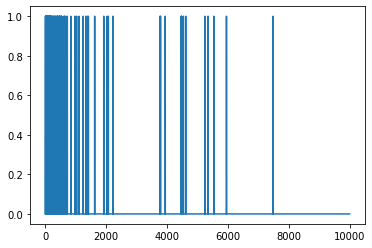

In [18]:
plt.plot(train_data[0])

## 演示过拟合

防止过度拟合的最简单方法是减小模型的大小，即模型中可学习参数的数量（由层数和每层单元数决定）。在深度学习中，模型中可学习参数的数量通常被称为模型的“容量”。直观地，具有更多参数的模型将具有更多的“记忆能力”，因此将能够容易地学习训练样本与其目标之间的完美的字典式映射，没有任何泛化能力的映射，但是在对未见过的数据做出预测时这将是无用的。

始终牢记这一点：深度学习模型往往善于适应训练数据，但真正的挑战是泛化，而不是适应。

另一方面，如果网络具有有限的记忆资源，则将不能容易地学习映射。为了最大限度地减少损失，它必须学习具有更强预测能力的压缩表示。同时，如果您使模型太小，则难以适应训练数据。“太多容量”和“容量不足”之间存在平衡。

不幸的是，没有神奇的公式来确定模型的正确大小或架构（就层数而言，或每层的正确大小），您将不得不尝试使用一系列不同的架构。

要找到合适的模型大小，最好从相对较少的层和参数开始，然后开始增加层的大小或添加新层，直到您看到验证损失的收益递减为止。让我们在电影评论分类网络上试试。

我们将仅适用`Dense`层作为基线创建一个简单模型，然后创建更小和更大的版本，并进行比较。

### 创建一个基线模型

In [19]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [20]:
baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.4708 - accuracy: 0.8157 - binary_crossentropy: 0.4708 - val_loss: 0.3302 - val_accuracy: 0.8740 - val_binary_crossentropy: 0.3302
Epoch 2/20
25000/25000 - 2s - loss: 0.2388 - accuracy: 0.9149 - binary_crossentropy: 0.2388 - val_loss: 0.2821 - val_accuracy: 0.8875 - val_binary_crossentropy: 0.2821
Epoch 3/20
25000/25000 - 2s - loss: 0.1760 - accuracy: 0.9380 - binary_crossentropy: 0.1760 - val_loss: 0.2921 - val_accuracy: 0.8841 - val_binary_crossentropy: 0.2921
Epoch 4/20
25000/25000 - 3s - loss: 0.1381 - accuracy: 0.9537 - binary_crossentropy: 0.1381 - val_loss: 0.3169 - val_accuracy: 0.8774 - val_binary_crossentropy: 0.3169
Epoch 5/20
25000/25000 - 3s - loss: 0.1107 - accuracy: 0.9645 - binary_crossentropy: 0.1107 - val_loss: 0.3433 - val_accuracy: 0.8733 - val_binary_crossentropy: 0.3433
Epoch 6/20
25000/25000 - 2s - loss: 0.0894 - accuracy: 0.9724 - binary_crossentropy: 0.0894 - val_loss: 0.3864

### 创建一个更小的模型

让我们创建一个隐藏单元较少的模型，与我们刚刚创建的基线模型进行比较：

In [21]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 4)                 40004     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


用相同的数据训练模型：

In [22]:
smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.6005 - accuracy: 0.6958 - binary_crossentropy: 0.6005 - val_loss: 0.5323 - val_accuracy: 0.7846 - val_binary_crossentropy: 0.5323
Epoch 2/20
25000/25000 - 2s - loss: 0.4829 - accuracy: 0.8542 - binary_crossentropy: 0.4829 - val_loss: 0.4885 - val_accuracy: 0.8286 - val_binary_crossentropy: 0.4885
Epoch 3/20
25000/25000 - 2s - loss: 0.4357 - accuracy: 0.8952 - binary_crossentropy: 0.4357 - val_loss: 0.4638 - val_accuracy: 0.8611 - val_binary_crossentropy: 0.4638
Epoch 4/20
25000/25000 - 2s - loss: 0.4032 - accuracy: 0.9186 - binary_crossentropy: 0.4032 - val_loss: 0.4515 - val_accuracy: 0.8686 - val_binary_crossentropy: 0.4515
Epoch 5/20
25000/25000 - 2s - loss: 0.3782 - accuracy: 0.9340 - binary_crossentropy: 0.3782 - val_loss: 0.4508 - val_accuracy: 0.8588 - val_binary_crossentropy: 0.4508
Epoch 6/20
25000/25000 - 2s - loss: 0.3571 - accuracy: 0.9428 - binary_crossentropy: 0.3571 - val_loss: 0.4457

### 创建一个较大的模型

作为练习，您可以创建一个更大的模型，并查看它开始过拟合的速度。
接下来，让我们在这个基准测试中添加一个容量更大的网络，远远超出问题的范围：

In [26]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


并且，再次使用相同的数据训练模型：

In [24]:
bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 8s - loss: 0.3582 - accuracy: 0.8463 - binary_crossentropy: 0.3582 - val_loss: 0.2819 - val_accuracy: 0.8848 - val_binary_crossentropy: 0.2819
Epoch 2/20
25000/25000 - 8s - loss: 0.1410 - accuracy: 0.9474 - binary_crossentropy: 0.1410 - val_loss: 0.3174 - val_accuracy: 0.8789 - val_binary_crossentropy: 0.3174
Epoch 3/20
25000/25000 - 8s - loss: 0.0403 - accuracy: 0.9876 - binary_crossentropy: 0.0403 - val_loss: 0.4361 - val_accuracy: 0.8707 - val_binary_crossentropy: 0.4361
Epoch 4/20
25000/25000 - 8s - loss: 0.0054 - accuracy: 0.9992 - binary_crossentropy: 0.0054 - val_loss: 0.5908 - val_accuracy: 0.8695 - val_binary_crossentropy: 0.5908
Epoch 5/20
25000/25000 - 8s - loss: 0.0013 - accuracy: 1.0000 - binary_crossentropy: 0.0013 - val_loss: 0.6677 - val_accuracy: 0.8709 - val_binary_crossentropy: 0.6677
Epoch 6/20
25000/25000 - 8s - loss: 1.9173e-04 - accuracy: 1.0000 - binary_crossentropy: 1.9173e-04 - val_loss

### 绘制训练和验证损失

<!--TODO(markdaoust): This should be a one-liner with tensorboard -->

实线表示训练损失，虚线表示验证损失（记住：较低的验证损失表示更好的模型）。在这里，较小的网络开始过拟合晚于基线模型（在6个周期之后而不是4个周期），并且一旦开始过拟合，其性能下降得慢得多。

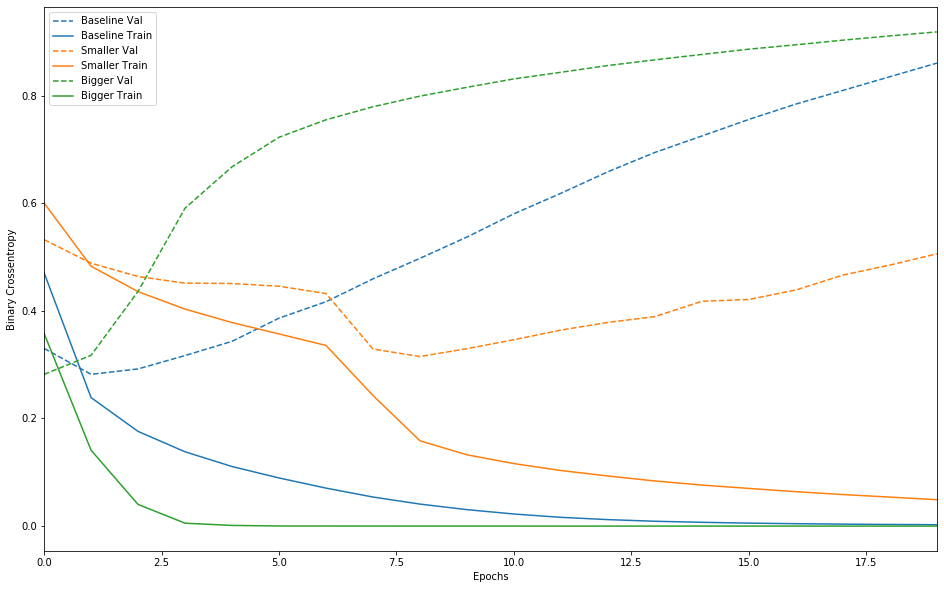

In [27]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

请注意，较大的网络在仅仅一个周期之后几乎立即开始过度拟合，并且更严重。网络容量越大，能够越快地对训练数据进行建模（导致训练损失低），但过拟合的可能性越大（导致训练和验证损失之间的差异很大）。

## 防止过拟合的策略

### 添加权重正则化



你可能熟悉奥卡姆的剃刀原则：给出两个解释的东西，最可能正确的解释是“最简单”的解释，即做出最少量假设的解释。这也适用于神经网络学习的模型：给定一些训练数据和网络架构，有多组权重值（多个模型）可以解释数据，而简单模型比复杂模型更不容易过度拟合。

在这种情况下，“简单模型”是参数值分布的熵更小的模型(或参数更少的模型，如我们在上一节中看到的)。因此，减轻过度拟合的一种常见方法是通过强制网络的权值只取较小的值来限制网络的复杂性，这使得权值的分布更加“规则”。这被称为“权重正则化”，它是通过在网络的损失函数中增加与权重过大相关的成本来实现的。这种成本有两种:

- [L1 正则化](https://developers.google.cn/machine-learning/glossary/#L1_regularization)其中添加的成本与权重系数的绝对值成正比(即与权重的“L1范数”成正比)。
- [L2 正则化](https://developers.google.cn/machine-learning/glossary/#L2_regularization), 其中增加的成本与权重系数值的平方成正比(即与权重的平方“L2范数”成正比)。L2正则化在神经网络中也称为权值衰减。不要让不同的名称迷惑你:权重衰减在数学上与L2正则化是完全相同的。

L2正则化引入了稀疏性，使一些权重参数为零。L2正则化将惩罚权重参数而不会使它们稀疏，这是L2更常见的一个原因。

在`tf.keras`中，通过将权重正则化实例作为关键字参数传递给层来添加权重正则化。我们现在添加L2权重正则化。

In [28]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.5398 - accuracy: 0.7868 - binary_crossentropy: 0.5001 - val_loss: 0.3827 - val_accuracy: 0.8736 - val_binary_crossentropy: 0.3413
Epoch 2/20
25000/25000 - 2s - loss: 0.3018 - accuracy: 0.9080 - binary_crossentropy: 0.2564 - val_loss: 0.3326 - val_accuracy: 0.8889 - val_binary_crossentropy: 0.2843
Epoch 3/20
25000/25000 - 2s - loss: 0.2502 - accuracy: 0.9309 - binary_crossentropy: 0.1994 - val_loss: 0.3384 - val_accuracy: 0.8854 - val_binary_crossentropy: 0.2857
Epoch 4/20
25000/25000 - 3s - loss: 0.2232 - accuracy: 0.9437 - binary_crossentropy: 0.1688 - val_loss: 0.3499 - val_accuracy: 0.8827 - val_binary_crossentropy: 0.2943
Epoch 5/20
25000/25000 - 3s - loss: 0.2078 - accuracy: 0.9486 - binary_crossentropy: 0.1510 - val_loss: 0.3650 - val_accuracy: 0.8787 - val_binary_crossentropy: 0.3074
Epoch 6/20
25000/25000 - 2s - loss: 0.1968 - accuracy: 0.9540 - binary_crossentropy: 0.1380 - val_loss: 0.3791

```l2（0.001）```表示该层的权重矩阵中的每个系数都会将```0.001 * weight_coefficient_value**2```添加到网络的总损失中。请注意，由于此惩罚仅在训练时添加，因此在训练时该网络的损失将远高于测试时。

这是我们的L2正则化惩罚的影响：

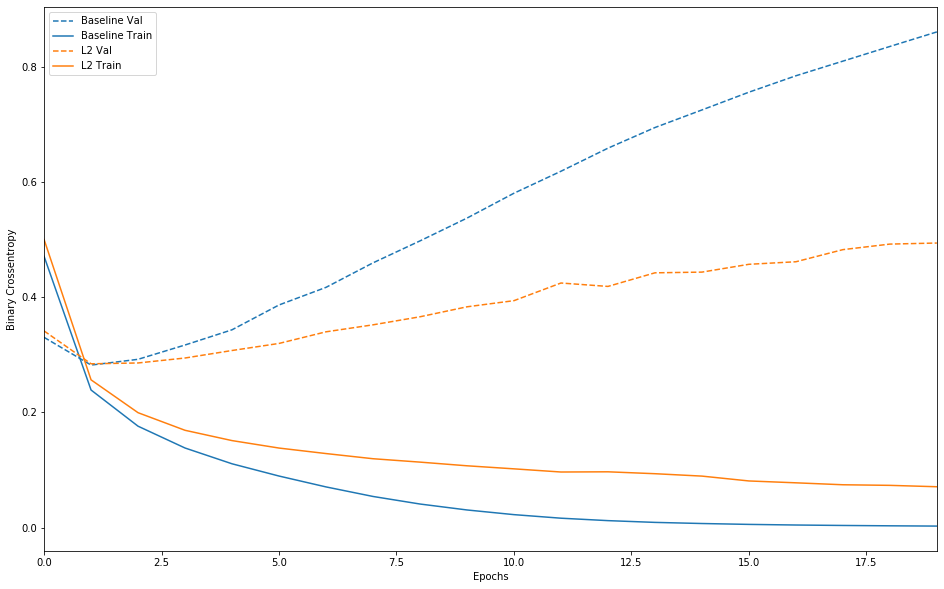

In [29]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

正如你所看到的，L2正则化模型比基线模型更能抵抗过拟合，即使两个模型具有相同数量的参数。

### 添加Dropout(丢弃正则化)

Dropout是由Hinton和他在多伦多大学的学生开发的最有效和最常用的神经网络正则化技术之一。Dropout应用于层主要就是在训练期间随机“丢弃”（即设置为零）该层的多个输出特征。假设一个给定的层通常会在训练期间为给定的输入样本返回一个向量[0.2,0.5,1.3,0.8,1.1]，在应用了Dropout之后，该向量将具有随机分布的几个零条目，例如，[0,0.5,1.3,0,1.1]。“丢弃率”是被归零的特征的一部分，它通常设置在0.2和0.5之间，
在测试时，没有单元被剔除，而是将层的输出值按与丢弃率相等的因子缩小，以平衡实际活动的单元多余训练时的单元。

在`tf.keras`中，您可以通过`Dropout`层在网络中引入dropout，该层将在之前应用于层的输出。

让我们在IMDB网络中添加两个`Dropout`层，看看它们在减少过度拟合方面做得如何：

In [30]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 3s - loss: 0.6191 - accuracy: 0.6445 - binary_crossentropy: 0.6191 - val_loss: 0.4808 - val_accuracy: 0.8528 - val_binary_crossentropy: 0.4808
Epoch 2/20
25000/25000 - 2s - loss: 0.4603 - accuracy: 0.7956 - binary_crossentropy: 0.4603 - val_loss: 0.3492 - val_accuracy: 0.8781 - val_binary_crossentropy: 0.3492
Epoch 3/20
25000/25000 - 3s - loss: 0.3602 - accuracy: 0.8563 - binary_crossentropy: 0.3602 - val_loss: 0.2904 - val_accuracy: 0.8876 - val_binary_crossentropy: 0.2904
Epoch 4/20
25000/25000 - 3s - loss: 0.3009 - accuracy: 0.8851 - binary_crossentropy: 0.3009 - val_loss: 0.2758 - val_accuracy: 0.8884 - val_binary_crossentropy: 0.2758
Epoch 5/20
25000/25000 - 2s - loss: 0.2549 - accuracy: 0.9071 - binary_crossentropy: 0.2549 - val_loss: 0.2773 - val_accuracy: 0.8874 - val_binary_crossentropy: 0.2773
Epoch 6/20
25000/25000 - 2s - loss: 0.2228 - accuracy: 0.9196 - binary_crossentropy: 0.2228 - val_loss: 0.2864

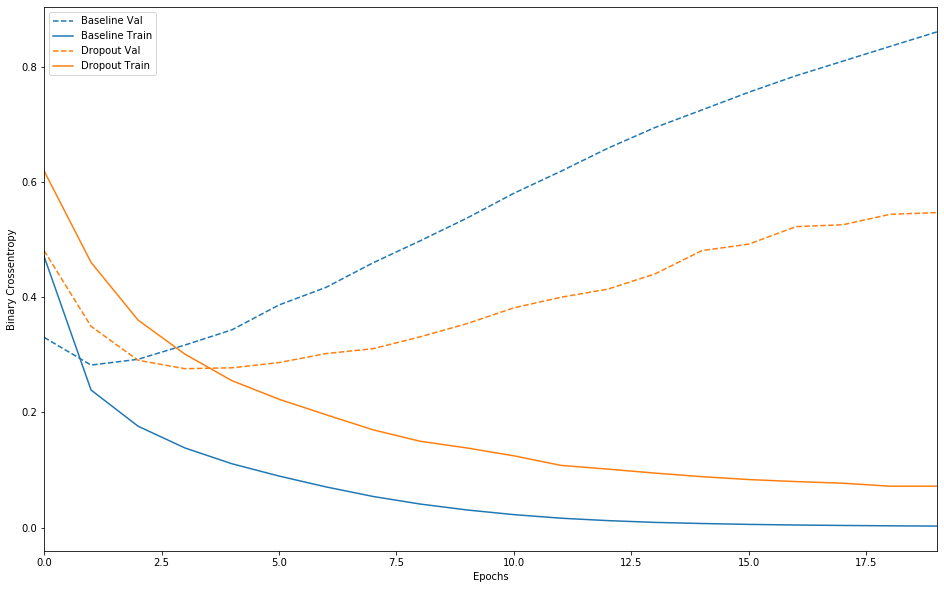

In [31]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

从上图可以看出，添加dropout时对基线模型的明显改进。

回顾一下，以下是防止神经网络中过度拟合的最常用方法：

- 获取更多训练数据
- 减少网络的容量
- 添加权重正则化
- 添加dropout

本指南未涉及的两个重要方法是数据增强和批量标准化。